In [2]:
# --- Import de packages ---

import pandas as pd
import taceconomics
from datetime import datetime
import numpy as np

from gdeltdoc import GdeltDoc, Filters
from datetime import datetime, timedelta
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, 
    precision_score, recall_score, f1_score, accuracy_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- API Key et dates ---

taceconomics.api_key = "sk_o24BhJRqVpIvxVSXX3yiKRGgpDEejmyJ8pfLFX2q22s"  
start_date = '2020-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")

In [4]:
# --- Importation des données ---

# Taux de change EUR/USD
usd_eur = taceconomics.getdata(f"EXR/EUR/WLD?start_date={start_date}")
usd_eur.columns = ["usd_eur"]
usd_eur = usd_eur.dropna()
eur_usd = 1 / usd_eur  # Inversion pour avoir EUR/USD
eur_usd.columns = ["close"]
eur_usd.index = pd.to_datetime(eur_usd.index)

print(eur_usd.head(10))
print(eur_usd.shape)
print(eur_usd.columns)

               close
timestamp           
2020-01-01  1.121830
2020-01-02  1.117088
2020-01-03  1.116000
2020-01-04  1.115949
2020-01-05  1.116159
2020-01-06  1.119650
2020-01-07  1.115418
2020-01-08  1.111278
2020-01-09  1.110868
2020-01-10  1.111971
(2091, 1)
Index(['close'], dtype='object')


In [5]:
# --- Indicateurs de base ---

# Rendement logarithmique quotidien
eur_usd["rendement_log"] = np.log(eur_usd["close"] / eur_usd["close"].shift(1))

# Volatilité glissante (30 jours) basée sur les rendements log
eur_usd["vol_30j"] = eur_usd["rendement_log"].rolling(window=30).std()

# Rendement logarithmique cumulé à 10 jours (passé)
eur_usd["rendement_log_10j"] = np.log(eur_usd["close"] / eur_usd["close"].shift(10))

# print(eur_usd.head(60))
print(eur_usd.shape)
print(eur_usd.columns)

(2091, 4)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j'], dtype='object')


In [6]:
# --- Cible --- 

# Rendement logarithmique FUTUR à 10 jours (cohérent avec les autres features)
eur_usd["rendement_futur_10j"] = np.log(eur_usd["close"].shift(-10) / eur_usd["close"])

# Seuils de choc dynamiques (±1 × volatilité sur 10 jours)
# La vol sur 10j est approximativement vol_quotidienne × sqrt(10)
seuil_choc = eur_usd["vol_30j"] * np.sqrt(10) # 1*vol car 2*vol est trop rare (4-5% des cas)

# Target : 1 si choc de volatilité (hausse OU baisse), 0 sinon
eur_usd["target"] = (
    (eur_usd["rendement_futur_10j"].abs() >= seuil_choc)
).astype(int)

print(eur_usd.shape)
print(eur_usd.columns)

# Distribution
print(f"\nDistribution de la target:")
print(eur_usd['target'].value_counts())
print(f"Taux de chocs: {eur_usd['target'].mean():.2%}")

(2091, 6)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j',
       'rendement_futur_10j', 'target'],
      dtype='object')

Distribution de la target:
target
0    1512
1     579
Name: count, dtype: int64
Taux de chocs: 27.69%


In [7]:
# --- Indicateurs chartistes ---

# Moyennes mobiles
eur_usd["mm7"] = eur_usd["close"].rolling(window=7).mean()
eur_usd["mm21"] = eur_usd["close"].rolling(window=21).mean()

# Bandes de Bollinger (20 jours)
rolling_mean_20 = eur_usd["close"].rolling(window=20).mean()
rolling_std_20 = eur_usd["close"].rolling(window=20).std()
eur_usd["boll_haut"] = rolling_mean_20 + 2 * rolling_std_20
eur_usd["boll_bas"] = rolling_mean_20 - 2 * rolling_std_20

# RSI
def calculer_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    perte = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=series.index).rolling(window=window).mean()
    avg_perte = pd.Series(perte, index=series.index).rolling(window=window).mean()
    rs = avg_gain / avg_perte
    rsi = 100 - (100 / (1 + rs))
    return rsi

eur_usd["rsi_14j"] = calculer_rsi(eur_usd["close"])

eur_usd = eur_usd.drop(columns=["rendement_futur_10j"])
# eur_usd = eur_usd.dropna().copy()

# print(eur_usd.head(60))
print(eur_usd.shape)
print(eur_usd.columns)
print(eur_usd.iloc[0])

(2091, 10)
Index(['close', 'rendement_log', 'vol_30j', 'rendement_log_10j', 'target',
       'mm7', 'mm21', 'boll_haut', 'boll_bas', 'rsi_14j'],
      dtype='object')
close                1.12183
rendement_log            NaN
vol_30j                  NaN
rendement_log_10j        NaN
target               0.00000
mm7                      NaN
mm21                     NaN
boll_haut                NaN
boll_bas                 NaN
rsi_14j                  NaN
Name: 2020-01-01 00:00:00, dtype: float64


In [8]:
# --- Indicateurs de sentiment ---

# Télécharger VADER (une seule fois)
nltk.download('vader_lexicon')

# Initialiser VADER globalement
sid = SentimentIntensityAnalyzer()

def recuperer_sentiment_gdelt(start_date, end_date, keyword="EUR/USD", language='eng', chunk_days=30, num_records=250):
    """
    Récupère les articles GDELT pour un mot-clé donné entre deux dates,
    calcule le score de sentiment pour chaque article, et agrège par jour.
    """
    # Convertir les dates
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    gd = GdeltDoc()
    all_articles = []

    current_start = start
    while current_start <= end:
        current_end = min(current_start + timedelta(days=chunk_days), end)

        # print(f"Récupération articles: {current_start.date()} -> {current_end.date()}")

        # Créer filtre
        f = Filters(
            start_date=current_start.strftime("%Y-%m-%d"),
            end_date=current_end.strftime("%Y-%m-%d"),
            num_records=num_records,
            keyword=keyword,
            language=language
        )

        # Récupérer articles
        try:
            articles_df = gd.article_search(f)
            if not articles_df.empty:
                all_articles.append(articles_df)
        except Exception as e:
            print(f"Erreur récupération: {e}")

        current_start = current_end + timedelta(days=1)

    # Vérifier si on a récupéré des articles
    if not all_articles:
        print("Aucun article trouvé pour la période.")
        return pd.DataFrame(columns=['date', 'sentiment'])

    df = pd.concat(all_articles, ignore_index=True)

    # Parsing date GDELT
    def convertir_date_gdelt(date_str):
        try:
            # Format AAAAMMJJTHHMMSSZ ou AAAAMMJJ
            date_part = date_str.split('T')[0]
            return datetime.strptime(date_part, "%Y%m%d").date()
        except:
            return pd.NaT

    df['date'] = df['seendate'].apply(convertir_date_gdelt)
    df = df.dropna(subset=['date'])
    df['date'] = pd.to_datetime(df['date'])

    # Calculer sentiment pour chaque article
    def calculer_sentiment(texte):
        if isinstance(texte, str) and texte.strip():
            return sid.polarity_scores(texte)['compound']
        return 0

    df['sentiment'] = df['title'].apply(calculer_sentiment)

    # Agréger par jour : score moyen par jour
    df_daily = df.groupby('date')['sentiment'].mean().reset_index()

    return df_daily

start_date = eur_usd.iloc[0].name.strftime("%Y-%m-%d")
end_date = eur_usd.iloc[-1].name.strftime("%Y-%m-%d")

print(f"Récupération sentiment GDELT de {start_date} à {end_date}")

df_sentiment = recuperer_sentiment_gdelt(
    start_date=start_date,
    end_date=end_date,
    keyword="EUR/USD",
    language='eng',
    chunk_days=30,
    num_records=250
)

df_sentiment = df_sentiment.groupby('date')['sentiment'].mean()
df_sentiment.index = pd.to_datetime(df_sentiment.index)

print(df_sentiment.head(10))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Récupération sentiment GDELT de 2020-01-01 à 2025-10-06
date
2020-01-02    0.190900
2020-01-03    0.130617
2020-01-04    0.000000
2020-01-05    0.347500
2020-01-06    0.094446
2020-01-07    0.079294
2020-01-08    0.046578
2020-01-09    0.003115
2020-01-10   -0.022136
2020-01-11   -0.323700
Name: sentiment, dtype: float64


In [9]:
# --- Fusion des données de sentiment avec les données EUR/USD ---

eur_usd = eur_usd.merge(df_sentiment.rename("sentiment"), left_index=True, right_index=True, how='left')

# Remplir les NaN si aucun article
eur_usd['sentiment'] = eur_usd['sentiment'].fillna(0)

print(eur_usd.head(10))
print(eur_usd.isna().sum())

               close  rendement_log  vol_30j  rendement_log_10j  target  \
timestamp                                                                 
2020-01-01  1.121830            NaN      NaN                NaN       0   
2020-01-02  1.117088      -0.004236      NaN                NaN       0   
2020-01-03  1.116000      -0.000974      NaN                NaN       0   
2020-01-04  1.115949      -0.000046      NaN                NaN       0   
2020-01-05  1.116159       0.000187      NaN                NaN       0   
2020-01-06  1.119650       0.003123      NaN                NaN       0   
2020-01-07  1.115418      -0.003787      NaN                NaN       0   
2020-01-08  1.111278      -0.003719      NaN                NaN       0   
2020-01-09  1.110868      -0.000369      NaN                NaN       0   
2020-01-10  1.111971       0.000992      NaN                NaN       0   

                 mm7  mm21  boll_haut  boll_bas  rsi_14j  sentiment  
timestamp                    

In [10]:
# --- Variables PCA & Clustering ---

# Copie sécurisée
df = eur_usd.dropna().copy()

# Sélection des features quantitatives 
# On exclut les colonnes non numériques ou non pertinentes
features = df.drop(columns=['target'], errors='ignore').select_dtypes(include=[np.number])

# Standardisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA (réduction de dimension) 
# Garde assez de composantes pour expliquer 90 % de la variance
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
df_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=df.index
)

# KMeans (clustering sur l’espace PCA) 
# Trouve des structures cachées dans les données
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_pca)

# Fusion finale 
df_extended = pd.concat([df, df_pca], axis=1)

# Résumé 
print(f"Variance expliquée par PCA : {pca.explained_variance_ratio_.sum():.2%}")
print(f"Nombre de composantes PCA retenues : {pca.n_components_}")
print(f"Forme finale du DataFrame : {df_extended.shape}")
print(df_extended.iloc[0])
print(df_extended.iloc[-1])
print(df_extended.columns)

Variance expliquée par PCA : 97.39%
Nombre de composantes PCA retenues : 5
Forme finale du DataFrame : (2061, 17)
close                 1.109510
rendement_log         0.005997
vol_30j               0.002222
rendement_log_10j     0.000899
target                1.000000
mm7                   1.103288
mm21                  1.107871
boll_haut             1.116823
boll_bas              1.098506
rsi_14j              51.143617
sentiment             0.063062
cluster_kmeans        0.000000
PC1                   0.199053
PC2                   0.476094
PC3                   0.258992
PC4                   1.652483
PC5                  -0.904424
Name: 2020-01-31 00:00:00, dtype: float64
close                 1.170988
rendement_log        -0.000158
vol_30j               0.003389
rendement_log_10j     0.004078
target                0.000000
mm7                   1.172913
mm21                  1.174829
boll_haut             1.184686
boll_bas              1.164821
rsi_14j              46.112106
sentime

In [11]:
# ---- Variables macro ----

start_date = df_extended.index[0].strftime("%Y-%m-%d")
end_date   = df_extended.index[-1].strftime("%Y-%m-%d")

print(f"Récupération variables macro de {start_date} à {end_date}")

infl_eur = taceconomics.getdata(
    f"EUROSTAT/EI_CPHI_M_CP-HI00_NSA_HICP2015/EUZ?collapse=D&transform=growth_yoy&start_date={start_date}"
)
infl_us = taceconomics.getdata(
    f"FRED/CPIAUCSL/USA?collapse=D&transform=growth_yoy&start_date={start_date}"
)
ti_eur = taceconomics.getdata(
    f"ECB/FM_D_EUR_4F_KR_DFR_LEV/EUZ?collapse=D&collapse_mode=end_of_period&start_date={start_date}"
)
ti_us = taceconomics.getdata(
    f"DS/USPRATE./WLD?collapse=D&start_date={start_date}"
)

infl_eur = infl_eur.squeeze()
infl_us  = infl_us.squeeze()
ti_eur   = ti_eur.squeeze()
ti_us    = ti_us.squeeze()

for s in [infl_eur, infl_us, ti_eur, ti_us]:
    s.index = pd.to_datetime(s.index).tz_localize(None)

df_macro = pd.DataFrame({
    "inflation_eur": infl_eur,
    "inflation_us": infl_us,
    "interest_rate_eur": ti_eur,
    "interest_rate_us": ti_us,
})


if df_macro.index[-1] < pd.to_datetime(end_date):
    full_index = pd.date_range(start=df_macro.index[0], end=end_date, freq="D")
    df_macro = df_macro.reindex(full_index).ffill()

print("Macro étendue :")
print(df_macro.index[0], "→", df_macro.index[-1])
print(df_macro.head(3))
print(df_macro.tail(3))

Récupération variables macro de 2020-01-31 à 2025-10-06
Macro étendue :
2020-01-31 00:00:00 → 2025-10-06 00:00:00
            inflation_eur  inflation_us  interest_rate_eur  interest_rate_us
2020-01-31       1.359619      2.599768               -0.5              1.75
2020-02-01       1.219748      2.341317               -0.5              1.75
2020-02-02       1.219748      2.341317               -0.5              1.75
            inflation_eur  inflation_us  interest_rate_eur  interest_rate_us
2025-10-04       2.227488       2.93922                2.0              4.25
2025-10-05       2.227488       2.93922                2.0              4.25
2025-10-06       2.227488       2.93922                2.0              4.25


In [13]:
df_final = pd.concat([df_extended, df_macro], axis=1)
df_final = df_final.ffill()
desc = df_final.describe()
print(df_final.tail(10))
print(df_final.columns)
print(df_final.iloc[0])

               close  rendement_log   vol_30j  rendement_log_10j  target  \
2025-09-27  1.170254       0.000000  0.003763          -0.010470     0.0   
2025-09-28  1.170682       0.000365  0.003763          -0.007059     0.0   
2025-09-29  1.173117       0.002078  0.003781          -0.001227     0.0   
2025-09-30  1.173530       0.000352  0.003781          -0.000875     0.0   
2025-10-01  1.173351      -0.000153  0.003762          -0.000258     0.0   
2025-10-02  1.173351      -0.000153  0.003762          -0.000258     0.0   
2025-10-03  1.174117       0.000653  0.003524          -0.005037     0.0   
2025-10-04  1.174117       0.000000  0.003506          -0.006176     0.0   
2025-10-05  1.171173      -0.002511  0.003541          -0.002762     0.0   
2025-10-06  1.170988      -0.000158  0.003389           0.004078     0.0   

                 mm7      mm21  boll_haut  boll_bas    rsi_14j  ...  \
2025-09-27  1.173747  1.174864   1.185024  1.165063  47.036885  ...   
2025-09-28  1.173323 

In [51]:
df_final.to_excel("data/test_eur_usd_data.xlsx")


Train: (1660, 20) | Test: (416, 20)

Meilleurs paramètres trouvés :
{'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.9, 'scale_pos_weight': np.float64(2.4947368421052634)}

AUC:        0.6636
Gini:       0.3272
Seuil:      0.4699

Confusion Matrix:
  TN= 192  FP= 119
  FN=  38  TP=  67

Precision:  0.3602
Recall:     0.6381
F1-Score:   0.4605
Accuracy:   0.6226


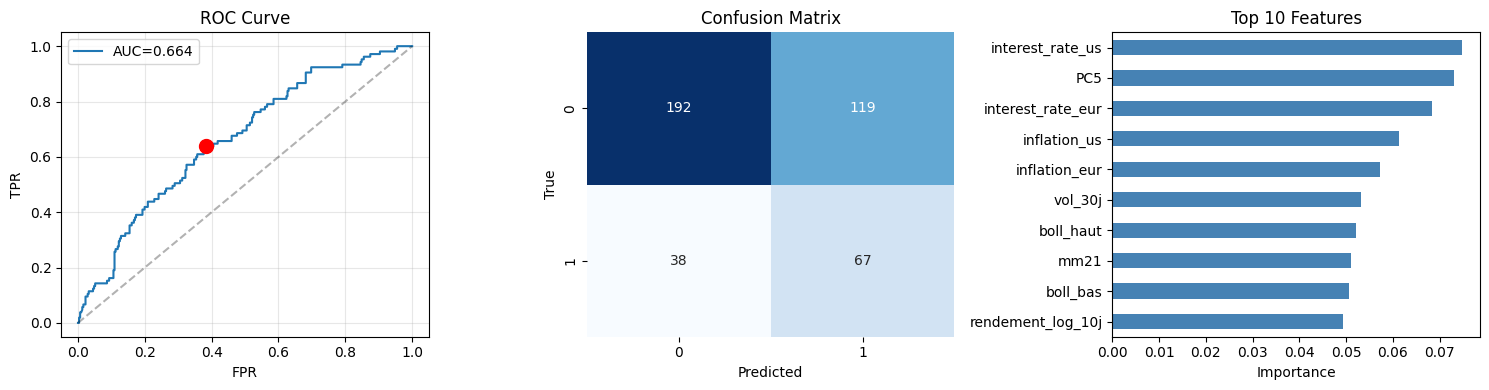


Top 5 features:
interest_rate_us     0.074904
PC5                  0.072986
interest_rate_eur    0.068337
inflation_us         0.061328
inflation_eur        0.057197
dtype: float32


In [18]:
# --- Import des packages ---
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             precision_score, recall_score, f1_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# --- Config ---
TRAIN_SIZE = 0.80  # 80% train, 20% test
df = df_final.copy()

# --- Features et target ---
feature_cols = ['close', 'rendement_log', 'vol_30j', 'rendement_log_10j',
       'mm7', 'mm21', 'boll_haut', 'boll_bas', 'rsi_14j', 'sentiment',
       'cluster_kmeans', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'inflation_eur',
       'inflation_us', 'interest_rate_eur', 'interest_rate_us']

X = df[feature_cols].fillna(df[feature_cols].median())
y = df["target"].astype(int)

# --- Split train/test temporel ---
split_idx = int(len(df) * TRAIN_SIZE)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTrain: {X_train.shape} | Test: {X_test.shape}")

# --- Définir la grille de paramètres ---
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [y_train.value_counts()[0] / y_train.value_counts()[1]]
}

# --- Recherche des meilleurs paramètres sans CV ---
best_auc = 0
best_params = None
best_model = None

for n_est in param_grid['n_estimators']:
    for max_d in param_grid['max_depth']:
        for lr in param_grid['learning_rate']:
            for subs in param_grid['subsample']:
                for col in param_grid['colsample_bytree']:
                    model = XGBClassifier(
                        n_estimators=n_est,
                        max_depth=max_d,
                        learning_rate=lr,
                        subsample=subs,
                        colsample_bytree=col,
                        scale_pos_weight=param_grid['scale_pos_weight'][0],
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric='logloss'
                    )
                    model.fit(X_train, y_train)
                    probs = model.predict_proba(X_test)[:, 1]
                    auc = roc_auc_score(y_test, probs)
                    if auc > best_auc:
                        best_auc = auc
                        best_params = {
                            'n_estimators': n_est,
                            'max_depth': max_d,
                            'learning_rate': lr,
                            'subsample': subs,
                            'colsample_bytree': col,
                            'scale_pos_weight': param_grid['scale_pos_weight'][0]
                        }
                        best_model = model

print("\nMeilleurs paramètres trouvés :")
print(best_params)

# --- Évaluation sur le test set ---
probs_test = best_model.predict_proba(X_test)[:, 1]

# Métriques ROC
auc = roc_auc_score(y_test, probs_test)
gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_test, probs_test)

# Seuil optimal (Youden)
youden_idx = np.argmax(tpr - fpr)
threshold = thresholds[youden_idx]

# Prédictions binaires
preds = (probs_test >= threshold).astype(int)

# Métriques
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
precision = precision_score(y_test, preds, zero_division=0)
recall = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)
accuracy = accuracy_score(y_test, preds)

print(f"\n{'='*50}")
print(f"AUC:        {auc:.4f}")
print(f"Gini:       {gini:.4f}")
print(f"Seuil:      {threshold:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={tn:4d}  FP={fp:4d}")
print(f"  FN={fn:4d}  TP={tp:4d}")
print(f"\nPrecision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")
print(f"Accuracy:   {accuracy:.4f}")
print(f"{'='*50}")

# --- Visualisations ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].scatter(fpr[youden_idx], tpr[youden_idx], c='red', s=100, zorder=5)
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Matrice de confusion
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix")
axes[1].set_ylabel("True")
axes[1].set_xlabel("Predicted")

# Feature Importance
importance = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=True)
importance.tail(10).plot(kind='barh', ax=axes[2], color='steelblue')
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Features")

plt.tight_layout()
plt.show()

print("\nTop 5 features:")
print(importance.sort_values(ascending=False).head(5))
